In [5]:
# Add .. to sys.path to import the module
import sys
import os
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# for notebook do the same thing as above 
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))


In [6]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from tqdm.auto import tqdm


from src.data.synthetic_data import sphere_data 

/raid/home/bournez_pie/mva_geom/mva_geom_24/NPM3D/Project/Noise2NoiseMapping_pytorch/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Torch CUDA version:", torch.version.cuda)

Using device: cuda
Torch CUDA version: 12.1


In [3]:
def display_result_3D(f, resolution=100, filename=None, figsize=(14, 5), title="3D SDF Result", eps=0.0):
    device = next(f.parameters()).device  
   
    lin = torch.linspace(-1, 1, resolution, device=device)
    grid_x, grid_y, grid_z = torch.meshgrid(lin, lin, lin, indexing='ij')
    coords = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)
    coords.requires_grad = True
    
    sdf = f(coords).squeeze()
    sdf_volume = sdf.reshape(resolution, resolution, resolution).detach().cpu().numpy()

    import matplotlib.pyplot as plt
    slice_axis = 2
    num_slices = 5
    slice_indices = np.linspace(0, resolution-1, num_slices, dtype=int)
    fig, axes = plt.subplots(1, num_slices, figsize=figsize)
    for i, idx in enumerate(slice_indices):
        slice_img = sdf_volume[:, :, idx]  # slice along z-axis
        im = axes[i].imshow(slice_img, cmap='viridis', origin='lower', extent=[-1,1,-1,1])
        axes[i].set_title(f"Slice {idx}")
        axes[i].axis("off")
    fig.suptitle(title)
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.show()


In [4]:

class SirenLayer3D(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.fc = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                size = 1 / self.in_features
            else:
                size = np.sqrt(6 / self.in_features) / self.omega_0
            self.fc.weight.uniform_(-size, size)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.fc(x))

class SirenNet3D(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out, num_layers, skip=[], omega_0=30.0):
        super().__init__()
        self.num_layers = num_layers
        self.skip = [i in skip for i in range(num_layers)]
        self.omega_0 = omega_0
        layers = []
  
        layers.append(SirenLayer3D(in_features=dim_in, out_features=dim_hidden, is_first=True, omega_0=omega_0))
        for k in range(1, num_layers):
            layers.append(SirenLayer3D(in_features=dim_hidden, out_features=dim_hidden, is_first=False, omega_0=omega_0))
        self.skip.append(False)
        self.last_layer = nn.Linear(dim_hidden, dim_out, bias=True)
        size = np.sqrt(6 / dim_in) / self.omega_0
        with torch.no_grad():
            self.last_layer.weight.uniform_(-size, size)
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if self.skip[i]:
                x = x + layer(x)
            else:
                x = layer(x)
        return self.last_layer(x)


def gradient(y, x, grad_outputs=None):

    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, x, grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

def project_pc(net, input_pc):

    d = net(input_pc)
    grad_d = gradient(d, input_pc)
    grad_norm = torch.norm(grad_d, dim=1, keepdim=True) + 1e-8
    proj = input_pc - d * grad_d / grad_norm
    return proj






In [5]:
def plot_point_cloud_3D(points, title="Point Cloud", s=1):

    points_np = points.detach().cpu().numpy()
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points_np[:, 0], points_np[:, 1], points_np[:, 2], s=s)
    ax.set_title(title)
    plt.show()

def display_projection_3D(net, input_pc):

    proj = project_pc(net, input_pc)
    plot_point_cloud_3D(proj, title="Projected 3D Points", s=1)

def display_sdf_slices(net, resolution=100, slice_axis=2, num_slices=5):

    lin = torch.linspace(-1, 1, resolution, device=device)
    grid_x, grid_y, grid_z = torch.meshgrid(lin, lin, lin, indexing='ij')
    coords = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)
    coords.requires_grad = True

    sdf_values = net(coords).squeeze()
    sdf_volume = sdf_values.reshape(resolution, resolution, resolution).detach().cpu().numpy()


    slice_indices = np.linspace(0, resolution-1, num_slices, dtype=int)
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 3))
    for i, idx in enumerate(slice_indices):
        if slice_axis == 0:
            slice_img = sdf_volume[idx, :, :]
        elif slice_axis == 1:
            slice_img = sdf_volume[:, idx, :]
        else:
            slice_img = sdf_volume[:, :, idx]
        im = axes[i].imshow(slice_img, cmap='viridis', origin='lower', extent=[-1,1,-1,1])
        axes[i].set_title(f"Slice idx={idx}")
        axes[i].axis("off")
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.suptitle("SDF Slices")
    plt.show()

def display_loss(list_loss):

    plt.figure(figsize=(6, 4))
    for key, loss_list in list_loss.items():
        if loss_list:
            plt.plot(loss_list, label=f"{key} (final: {loss_list[-1]:.2f})")
    plt.xlabel("Epochs")
    plt.yscale("log")
    plt.legend()
    plt.title("Loss Curves")
    plt.show()



In [6]:
from src.optimize import optimize_nise_vf

In [ ]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(10000, 100000,dim=3)

plot_point_cloud_3D(pc0[::100], title="3D Sphere Points", s=5)

num_slices = 5
slice_indices = np.linspace(0, sdf_coords.shape[-1]-1, num_slices, dtype=int)
fig, axes = plt.subplots(1, num_slices, figsize=(15, 3))
sdf_np = sdf_coords.detach().cpu().numpy()
for i, idx in enumerate(slice_indices):
    im = axes[i].imshow(sdf_np[:, :, idx], cmap="viridis", origin="lower", extent=[-1,1,-1,1])
    axes[i].set_title(f"GT SDF Slice z={idx}")
    axes[i].axis("off")
fig.colorbar(im, ax=axes.ravel().tolist())
plt.suptitle("Ground Truth SDF Slices")
plt.show()


npl = 128
depth = 5
net = SirenNet3D(dim_in=3, dim_hidden=npl, dim_out=1, num_layers=depth, skip=[]).to(device)

test_input = torch.randn(2000, 3, device=device)
print("Network output shape (should be [2000, 1]):", net(test_input).shape)

from src.loss import compute_EMD
input_pc = torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
loss_val = compute_EMD(net, input_pc, 2000)
loss_val.backward()
print("Test computed EMD loss:", loss_val.item())

list_loss = {"emd": [], "gc": [], "eik": [], "hint": [], "pc": []}

pc_input = pc0.clone().to(device)
pc_input.requires_grad = True


nepochs = 5000


optimize_nise_vf(
    net=net,
    pc0=pc_input,
    hints0=pts_hints0,    
    gtsdf0=gt_sdf_hints0,
    lambda_pc=0,          
    lambda_eik=0.001,   
    lambda_hint=0,      
    lambda_lse=2,       
    lambda_gc=0.001,      
    lambda_emd=1,          
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=False,
    follow_paper=False,
    list_loss=list_loss,
)


torch.save(net, "net_vf_3D.net")


display_result_3D(net, resolution=200, figsize=(14, 5), title="Final 3D SDF Result")

display_sdf_slices(net, resolution=150, slice_axis=2, num_slices=5)

display_projection_3D(net, pc_input)

display_loss(list_loss)

In [ ]:
torch.save(net, "net_vf_3D.net")

In [6]:
model= torch.load("net_vf_3D.net")
net= model.to(device)
net.eval()

SirenNet3D(
  (last_layer): Linear(in_features=128, out_features=1, bias=True)
  (layers): ModuleList(
    (0): SirenLayer3D(
      (fc): Linear(in_features=3, out_features=128, bias=True)
    )
    (1-4): 4 x SirenLayer3D(
      (fc): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)

In [ ]:
del pc_input

In [ ]:
del input_pc



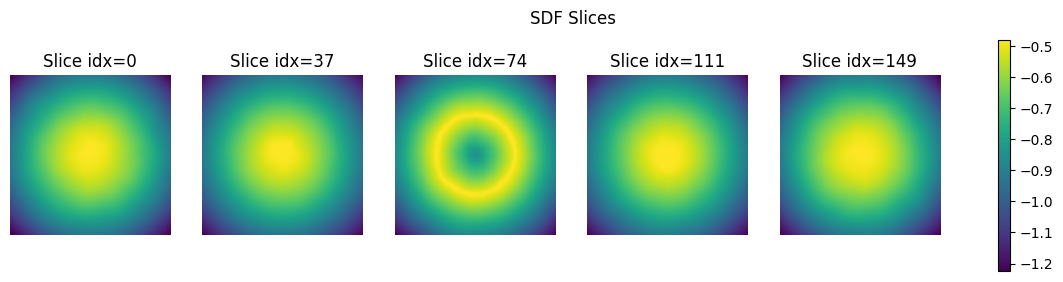

NameError: name 'pc_input' is not defined

In [11]:
display_sdf_slices(net, resolution=150, slice_axis=2, num_slices=5)

display_projection_3D(net, pc_input)

display_loss(list_loss)

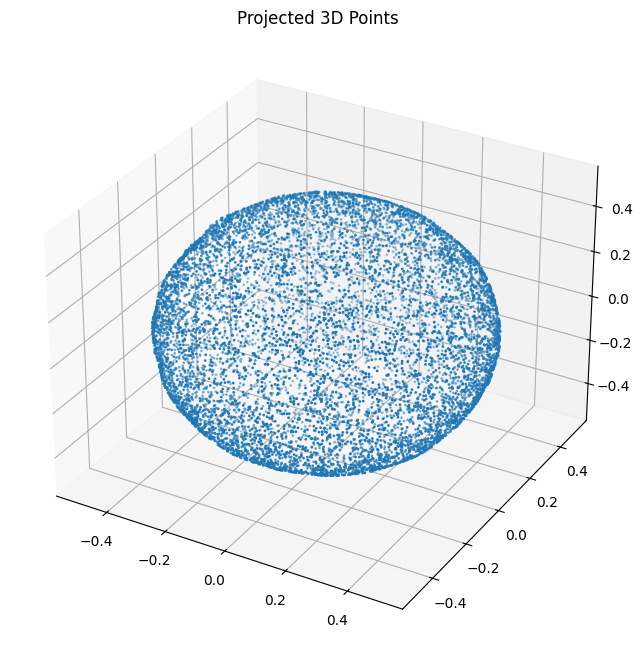

In [13]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(10000, 100000)
pc_input= pc0.to(device)
pc_input.requires_grad = True
display_projection_3D(net, pc_input)


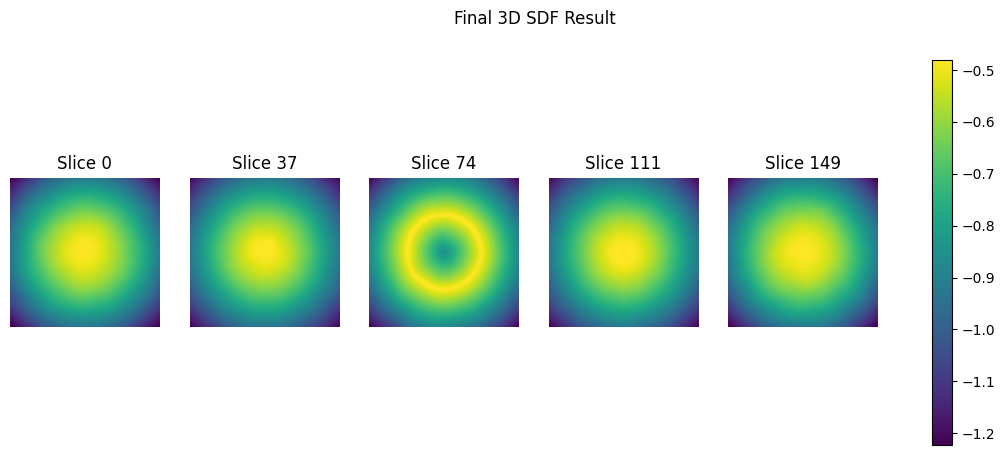

In [11]:
model= torch.load("net_vf_3D.net")
net= model.to(device)
net.eval()
net=net.to(device)
display_result_3D(net, resolution=150, figsize=(14, 5), title="Final 3D SDF Result")

In [ ]:
!nvidia-smi